In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [3]:
import sys
sys.path.append("scripts")
import rr_em

In [62]:
np.random.lognormal(2.0, 0.5, size=100)

array([12.92225731,  6.19794736, 12.17351755,  5.79745504,  7.19765103,
        5.27483004,  5.7789331 , 14.43646458,  5.01483881,  6.06592825,
        5.48558298, 10.53037623,  5.0266489 ,  6.62924713, 10.57493387,
        9.18617769, 15.4307084 ,  5.4424498 , 11.32354048,  4.93785847,
       21.07020875,  7.24091185, 22.64494711, 18.75727054,  6.33681331,
       16.36706955,  5.33079203, 12.63852838,  7.70722331, 10.14184152,
        7.07128541,  3.2249973 ,  7.74491311,  8.17471221,  7.53571873,
       10.83172297,  9.66221591, 15.71949457,  4.41337345,  3.67161105,
        5.00965659,  4.4918645 ,  6.0775649 , 12.70890122, 16.52672854,
       12.88207724,  9.29956454, 12.76480215,  7.52526133, 11.91451702,
        3.14487617,  6.44504736,  7.53354106, 25.0163983 , 16.98219907,
        6.07033433,  5.39189578,  9.33511466, 11.88585079,  4.07812679,
        9.42118053, 28.64336507,  5.8107856 , 13.02444393,  8.9378488 ,
        3.81299689, 13.33731424,  7.88425439,  7.7430805 ,  5.87

In [75]:
stim = rr_em.stimulus.RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=len(rr_em.generator.phoneme2idx),
                                              word_surprisal_params=(2.0, 0.5))
ds_args = dict(response_type="gaussian", epoch_window=(0.0, 1.0), include_intercept=False, sample_rate=48)
dataset = rr_em.generator.sample_dataset(rr_em.get_parameters(), stim, **ds_args)
test_dataset = rr_em.generator.sample_dataset(dataset.params, stim, **ds_args)

In [76]:
dataset.Y_epoch[:, :, 0]

tensor([[-1.1648, -0.6784, -0.0054,  ...,  0.4317,  0.4917,  1.0410],
        [-0.3951, -0.5708,  1.8270,  ...,  0.5044, -0.3499,  0.7530],
        [-1.3708,  0.4317,  0.4917,  ..., -0.9187,  0.8810, -0.4449],
        ...,
        [-1.3200,  0.2106,  0.0915,  ..., -0.0238, -0.2831, -0.4362],
        [-0.8987, -0.6388, -1.1309,  ..., -0.4640,  0.6098, -1.7062],
        [ 0.6098, -1.7062, -1.2114,  ...,  0.0537, -1.3778,  1.8795]])

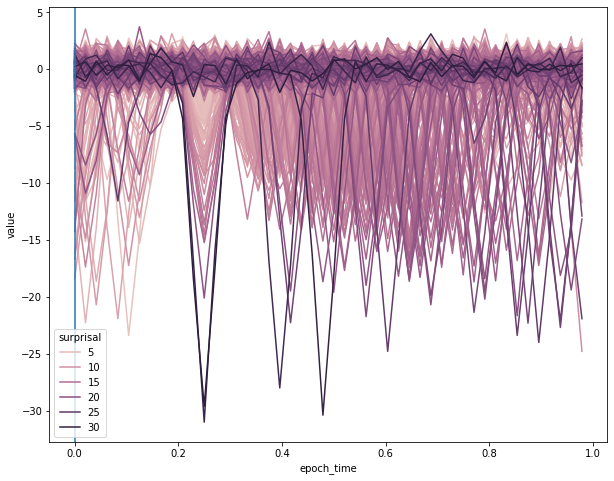

In [111]:
to_plot = pd.DataFrame(dataset.Y_epoch[:, :, 0])
to_plot.index.name = "epoch"
to_plot["surprisal"] = dataset.X_epoch[:, -1]
to_plot = to_plot.melt(id_vars=["surprisal"], var_name="epoch_time")
to_plot["epoch_time"] /= dataset.sample_rate
to_plot["epoch_time"] += dataset.epoch_window[0]

plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value", hue="surprisal")
plt.axvline(0.0)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='surprisal', ylabel='Density'>

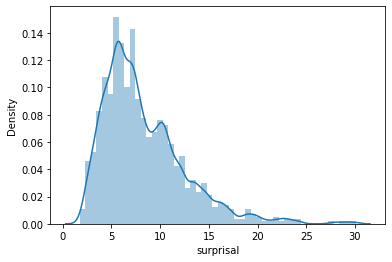

In [112]:
sns.distplot(to_plot.surprisal)

<AxesSubplot:xlabel='epoch_time', ylabel='value'>

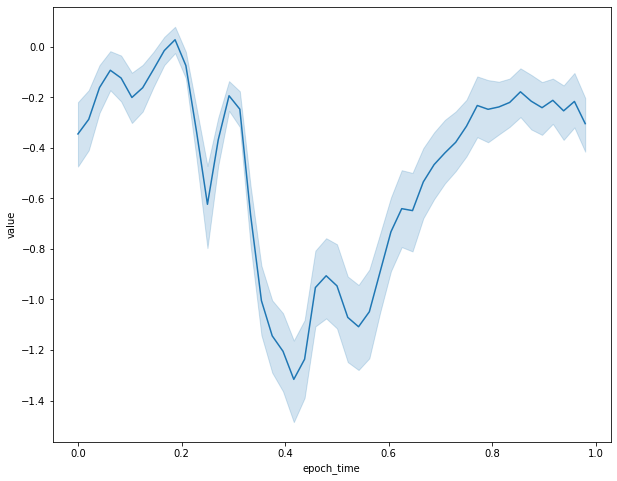

In [113]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value")

## MLE regression

Raw visualization above doesn't produce a very clean EEG response. Let's try estimating a TRF model on the full data and see if we can recover something.

In [81]:
from sklearn.model_selection import KFold

n_splits = 8
tmin, tmax = 0.0, 1.0
encoder = rr_em.TemporalReceptiveField(tmin, tmax, dataset.sample_rate, ["abc"], alpha=0)
n_features = dataset.X_epoch.shape[1]
coefs = torch.zeros((n_splits, len(encoder.delays_), n_features))

X_scatter = rr_em.rr.scatter_response_model(
    dataset.X_epoch,
    torch.zeros(dataset.X_epoch.shape[0]).long(),
    dataset.phoneme_onsets + dataset.word_onsets.unsqueeze(1),
    sample_rate=dataset.sample_rate,
    total_samples=dataset.Y.shape[0])

for i_split, (train, test) in enumerate(tqdm(KFold(n_splits, shuffle=True).split(X_scatter), total=n_splits)):
    encoder_i = encoder.fit(X_scatter[train], dataset.Y[train])
    coefs[i_split] = encoder_i.coef_

  0%|          | 0/8 [00:00<?, ?it/s]

In [82]:
coef_df = pd.DataFrame(coefs[:, :, 0])
coef_df.index.name = "fold"
coef_df = coef_df.reset_index().melt(id_vars=["fold"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate + dataset.epoch_window[0]
coef_df

,fold,epoch_sample,value,epoch_time
0,0,0,-0.003836,0.0
1,1,0,0.000482,0.0
2,2,0,-0.004452,0.0
3,3,0,-0.002641,0.0
4,4,0,0.000913,0.0
...,...,...,...,...
387,3,48,-0.015732,1.0
388,4,48,-0.019704,1.0
389,5,48,-0.013734,1.0
390,6,48,-0.018688,1.0


<AxesSubplot:xlabel='epoch_time', ylabel='value'>

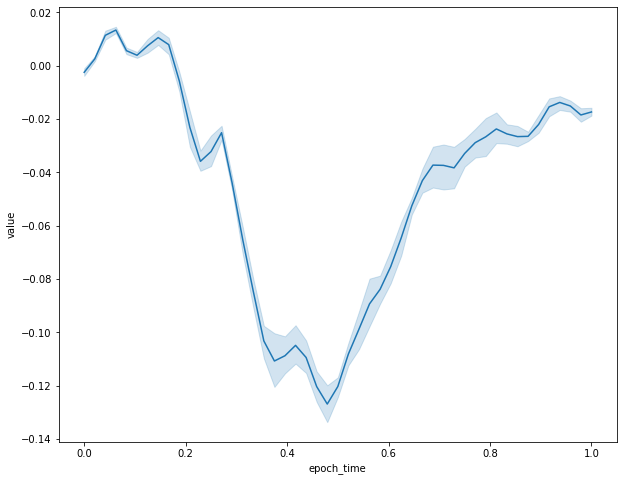

In [83]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value")

Nope, doesn't look right. We know the underlying response should peak at ~0.3 seconds. What we're seeing here conflates the response shape with the delayed onset of the response.

----

## EM regression with latent recognition

In [95]:
param_grid = [rr_em.get_parameters() for _ in range(50)]

In [118]:
weights, encoders = rr_em.fit_em(dataset, param_grid, test_dataset, n_iter=50, trf_alpha=1e-2,
                                 early_stopping_patience=5)

  0%|          | 0/50 [00:00<?, ?it/s]

In [101]:
coef_df = pd.DataFrame(torch.stack(encoders)[:, :, 0])
coef_df.index.name = "iter"
coef_df = coef_df.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate + dataset.epoch_window[0]
coef_df

,iter,epoch_sample,value,epoch_time
0,0,0,0.014295,0.0
1,1,0,-0.003574,0.0
2,2,0,-0.000099,0.0
3,3,0,-0.002945,0.0
4,4,0,-0.002944,0.0
...,...,...,...,...
760,46,14,-0.005398,0.291667
761,47,14,-0.005398,0.291667
762,48,14,-0.005398,0.291667
763,49,14,-0.005398,0.291667


<AxesSubplot:xlabel='epoch_time', ylabel='value'>

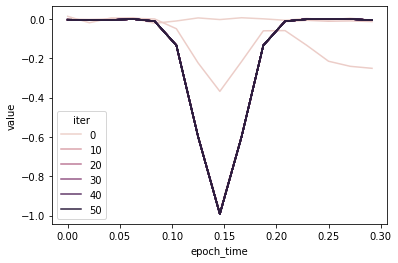

In [102]:
sns.lineplot(data=coef_df, x="epoch_time", y="value", hue="iter")

In [103]:
weights

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

<AxesSubplot:xlabel='component', ylabel='value'>

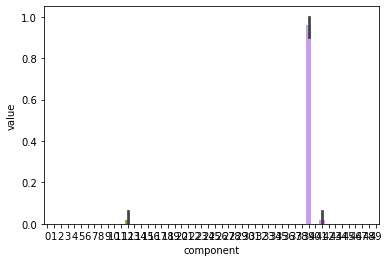

In [104]:
weight_df = pd.DataFrame(weights)
weight_df.index.name = "iter"
to_plot = weight_df.reset_index().melt(id_vars=["iter"], var_name="component")

# sns.FacetGrid(data=to_plot, row="iter").map(sns.barplot, "component", "value")
sns.barplot(data=to_plot, x="component", y="value")

In [106]:
thresholds = {k: params.threshold.numpy() for k, params in enumerate(param_grid)}
to_plot["threshold"] = to_plot.component.map(thresholds)

In [107]:
to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum())

iter
0     0.034378
1     0.671096
2     0.732393
3     0.732393
4     0.732393
5     0.732393
6     0.732393
7     0.732393
8     0.732393
9     0.732393
10    0.732393
11    0.732393
12    0.732393
13    0.732393
14    0.732393
15    0.732393
16    0.732393
17    0.732393
18    0.732393
19    0.732393
20    0.732393
21    0.732393
22    0.732393
23    0.732393
24    0.732393
25    0.732393
26    0.732393
27    0.732393
28    0.732393
29    0.732393
30    0.732393
31    0.732393
32    0.732393
33    0.732393
34    0.732393
35    0.732393
36    0.732393
37    0.732393
38    0.732393
39    0.732393
40    0.732393
41    0.732393
42    0.732393
43    0.732393
44    0.732393
45    0.732393
46    0.732393
47    0.732393
48    0.732393
49    0.732393
dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

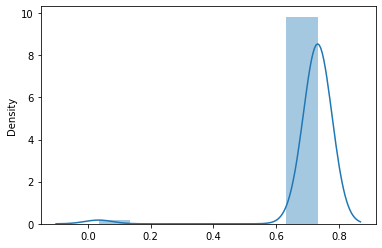

In [108]:
sns.distplot(to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum()))

In [109]:
dataset.params.threshold

tensor(0.7052)